In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

print(tf.version.VERSION)
print(tf.keras.__version__)

import os
import sys

import numpy as np

2.0.0
2.2.4-tf


In [3]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.PlotUtils import plot_history

In [4]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet',
                 include_top=False,
                 input_shape=(150, 150, 3))

# weights specifies the weight checkpoint from which to initialize the model.

# include_top refers to including (or not) the densely connected classifier on
# top of the network. By default, this densely connected classifier corresponds to
# the 1,000 classes from ImageNet.

# input_shape is the shape of the image tensors that you’ll feed to the network.
# This argument is purely optional: if you don’t pass it, the network will be able to
# process inputs of any size.

58892288/58889256 [==============================] - 4s 0us/step


In [5]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

2 ways to proceed:

1) Running the convolutional base over your dataset, recording its output to a
Numpy array on disk, and then using this data as input to a standalone, densely
connected classifier similar to those you saw in part 1 of this book. This solution
is fast and cheap to run, because it only requires running the convolutional
base once for every input image, and the convolutional base is by far the most
expensive part of the pipeline. But for the same reason, this technique won’t
allow you to use data augmentation.

2) Extending the model you have (conv_base) by adding Dense layers on top, and
running the whole thing end to end on the input data. This will allow you to use
data augmentation, because every input image goes through the convolutional
base every time it’s seen by the model. But for the same reason, this technique is
far more expensive than the first.

In [7]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = 'c:/Users/michal/PycharmProjects/ml-playground/data/dogs-vs-cats/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size=20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
#The extracted features are currently of shape (samples, 4, 4, 512). You’ll feed them
#to a densely connected classifier, so first you must flatten them to (samples, 8192):

train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))


In [9]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
loss='binary_crossentropy',
metrics=['acc'])


history = model.fit(train_features, train_labels,
epochs=30,
batch_size=20,
validation_data=(validation_features, validation_labels))


Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 3s 1ms/sample - loss: 0.5828 - acc: 0.6850 - val_loss: 0.4397 - val_acc: 0.8470
Epoch 2/30
2000/2000 [==============================] - 2s 909us/sample - loss: 0.4124 - acc: 0.8195 - val_loss: 0.3593 - val_acc: 0.8690
Epoch 3/30
2000/2000 [==============================] - 2s 890us/sample - loss: 0.3532 - acc: 0.8495 - val_loss: 0.3229 - val_acc: 0.8740
Epoch 4/30
2000/2000 [==============================] - 2s 901us/sample - loss: 0.3122 - acc: 0.8725 - val_loss: 0.3025 - val_acc: 0.8760
Epoch 5/30
2000/2000 [==============================] - 2s 911us/sample - loss: 0.2858 - acc: 0.8755 - val_loss: 0.2876 - val_acc: 0.8870
Epoch 6/30
2000/2000 [==============================] - 2s 893us/sample - loss: 0.2603 - acc: 0.9020 - val_loss: 0.2750 - val_acc: 0.8870
Epoch 7/30
2000/2000 [==============================] - 2s 891us/sample - loss: 0.2385 - acc: 0.9065 - val_loss: 0.2697 - val_

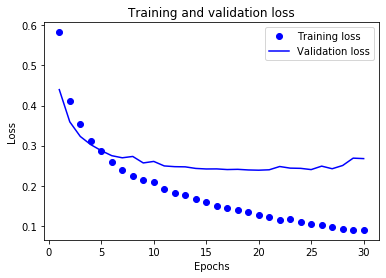

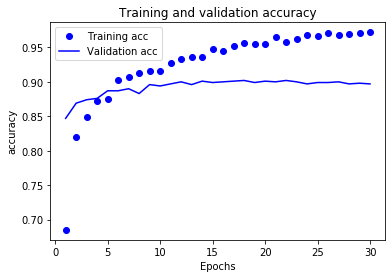

In [10]:
history_dict = history.history
#history_dict.keys()
#acc = history.history['acc']
#val_acc = history.history['val_acc']
#loss = history.history['loss']
#val_loss = history.history['val_loss']


plot_history(history_dict, what_to_plot=[('loss', 'Training loss'),('val_loss', 'Validation loss')], 
              title='Training and validation loss', xlabel='Epochs', ylabel='Loss')

plot_history(history_dict, what_to_plot=[('acc', 'Training acc'),('val_acc', 'Validation acc')], 
              title='Training and validation accuracy', xlabel='Epochs', ylabel='accuracy')

You reach a validation accuracy of about 90%—much better than you achieved in the
previous section with the small model trained from scratch. But the plots also indicate
that you’re overfitting almost from the start—despite using dropout with a fairly large
rate. That’s because this technique doesn’t use data augmentation, which is essential
for preventing overfitting with small image datasets.

FEATURE EXTRACTION WITH DATA AUGMENTATION

In [11]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [13]:
print('trainable_weights before freeze', len(model.trainable_weights))

trainable_weights before freeze 30


In [14]:
conv_base.trainable = False
print('trainable_weights after freeze', len(model.trainable_weights))

trainable_weights after freeze 4


In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')
    
model.compile(loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=2e-5),
    metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 651s 7s/step - loss: 0.6175 - acc: 0.6705 - val_loss: 0.4704 - val_acc: 0.8100
Epoch 2/30
100/100 [==============================] - 667s 7s/step - loss: 0.4831 - acc: 0.7880 - val_loss: 0.3800 - val_acc: 0.8470
Epoch 3/30
100/100 [==============================] - 647s 6s/step - loss: 0.4418 - acc: 0.8070 - val_loss: 0.3410 - val_acc: 0.8710
Epoch 4/30
100/100 [==============================] - 642s 6s/step - loss: 0.4099 - acc: 0.8145 - val_loss: 0.3161 - val_acc: 0.8740
Epoch 5/30
100/100 [==============================] - 618s 6s/step - loss: 0.3964 - acc: 0.8280 - val_loss: 0.3000 - val_acc: 0.8820
Epoch 6/30
100/100 [==============================] - 592s 6s/step - loss: 0.3877 - acc: 0.8285 - val_loss: 0.2955 - val_acc: 0.8740
Epoch 7/30
100/100 [==============================] - 664s 7s/step - loss: 0.3583 - acc: 0.8425 - val_loss: 0.2785 - v

In [17]:
model.save('cats_and_dogs_small_vgg_extended.h5')

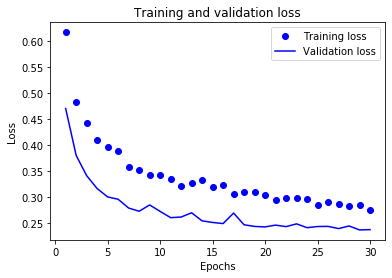

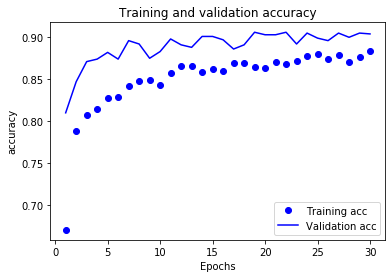

In [18]:
history_dict = history.history
#history_dict.keys()
#acc = history.history['acc']
#val_acc = history.history['val_acc']
#loss = history.history['loss']
#val_loss = history.history['val_loss']


plot_history(history_dict, what_to_plot=[('loss', 'Training loss'),('val_loss', 'Validation loss')], 
              title='Training and validation loss', xlabel='Epochs', ylabel='Loss')

plot_history(history_dict, what_to_plot=[('acc', 'Training acc'),('val_acc', 'Validation acc')], 
              title='Training and validation accuracy', xlabel='Epochs', ylabel='accuracy')

In [ ]:
# Fine tuning 

In [19]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [20]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model.compile(loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-5),
    metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 583s 6s/step - loss: 0.3080 - acc: 0.8665 - val_loss: 0.2144 - val_acc: 0.9150
Epoch 2/100
100/100 [==============================] - 584s 6s/step - loss: 0.2439 - acc: 0.8925 - val_loss: 0.2066 - val_acc: 0.9170
Epoch 3/100
100/100 [==============================] - 584s 6s/step - loss: 0.2312 - acc: 0.9000 - val_loss: 0.2190 - val_acc: 0.9120
Epoch 4/100
100/100 [==============================] - 584s 6s/step - loss: 0.2243 - acc: 0.9085 - val_loss: 0.1967 - val_acc: 0.9240
Epoch 5/100
100/100 [==============================] - 583s 6s/step - loss: 0.2109 - acc: 0.9125 - val_loss: 0.2333 - val_acc: 0.9110
Epoch 6/100
100/100 [==============================] - 584s 6s/step - loss: 0.1833 - acc: 0.9190 - val_loss: 0.1979 - val_acc: 0.9190
Epoch 7/100
100/100 [==============================] - 584s 6s/step - loss: 0.1856 - acc: 0.9225 - val_loss: 0.1999 - val_acc: 0.9180
Epoch 8/100
100/100 [==============================] - 585s 6s